# Sebastian Walter: Images shadow removal
[Video recording](https://youtu.be/3WWoGVIE5EI)

## IDEA

The HRSC (High-Resolution Stereo Camera) around Mars has a very elliptic orbit, therefore the images often have different illumination conditions. This makes it hard to mosaic them together. The idea here is to train a network for shadow removal.

![HRSC image](hrsc-vm-example.png "HRSC mosaic composed from differently illuminated single images")HRSC mosaic composed from differently illuminated single images

## DATA

We use two HRSC images for training and testing. One image has a low Sun incidence, the other image has a high Sun incidence angle. Both the images overlap, so we can create a paired dataset.

The images are "top-of-atmosphere" reflectance stored as float32.

Author: Sebastian Walter, Freie Universtaet Berlin.

In [1]:
!find input

input
input/h2233_0009.nd4.14_toa
input/h4127_0000.nd4.07_toa


In [2]:
#First load images, we use a class for this. The code was initially written to include additional data.

from osgeo import gdal
import numpy as np
import os

class imageStack:
    def __init__(self,filename):
        #self.band_type = None
        #self.bands = None
        #self.ct = None
        self.filename = None
        self.geotransform = None
        self.lrx = None
        self.lry = None
        self.projection = None
        self.ulx = None
        self.uly = None
        self.xsize = None
        self.ysize = None
        self.filename=filename
        ds=gdal.Open(filename + '_' + 'toa', gdal.GA_ReadOnly)
        self.xsize = ds.RasterXSize
        self.ysize = ds.RasterYSize
        self.projection=ds.GetProjection()
        self.geotransform=ds.GetGeoTransform()
        self.ulx = self.geotransform[0]
        #print(self.ulx)
        self.uly = self.geotransform[3]
        self.lrx = self.ulx + self.geotransform[1] * self.xsize
        self.lry = self.uly + self.geotransform[5] * self.ysize
        ds = None
    def load_data(self):
        self.data = np.zeros((2, self.ysize, self.xsize), dtype=np.float32)
        index = 0
        for imtype in ('toa',):
            #print(imtype)
            #print(os.path.exists(filename+'_'+imtype))
            filename = self.filename + '_' + imtype
            ds = gdal.Open(filename, gdal.GA_ReadOnly)
            a = ds.GetRasterBand(1).ReadAsArray()
            a[a < 0.] = np.nan
            #Normalize 0-1
            a = (a-np.nanmin(a))/(np.nanmax(a)-np.nanmin(a))
            self.data[index, :, :] = a
            ds = None
            index += 1
img1 = imageStack('modpreplev4/4127_0000/h4127_0000.nd4.07')
img1.load_data()
img2 = imageStack('modpreplev4/2233_0009/h2233_0009.nd4.14')
img2.load_data()
if img1.projection != img2.projection:
    print('Projections do not match!')
if img1.geotransform[1] != img2.geotransform[1]:
    print('Pixel sizes do not match!')

In [3]:
#Now we find the overlapping area to build pairs.

# figure out intersection region
ulx = max(img1.ulx, img2.ulx)
uly = min(img1.uly, img2.uly)
lrx = min(img1.lrx, img2.lrx)
lry = max(img1.lry, img2.lry)

# Compute img1 window in pixel coordinates.
img1_xoff = int((ulx - img1.geotransform[0]) / img1.geotransform[1] + 0.1)
img1_yoff = int((uly - img1.geotransform[3]) / img1.geotransform[5] + 0.1)
img1_xsize = int((lrx - img1.geotransform[0]) / img1.geotransform[1] + 0.5) - img1_xoff
img1_ysize = int((lry - img1.geotransform[3]) / img1.geotransform[5] + 0.5) - img1_yoff

# compute img2 window in pixel coordinates.
img2_xoff = int((ulx - img2.geotransform[0]) / img2.geotransform[1] + 0.1)
img2_yoff = int((uly - img2.geotransform[3]) / img2.geotransform[5] + 0.1)
img2_xsize = int((lrx - img2.geotransform[0]) / img2.geotransform[1] + 0.5) - img2_xoff
img2_ysize = int((lry - img2.geotransform[3]) / img2.geotransform[5] + 0.5) - img2_yoff

print(img1_xoff,img1_yoff)
print(img2_xoff,img2_yoff)
print(img1_xsize,img1_ysize)
print(img2_xsize,img2_ysize)


680 45440
0 0
4716 10246
4716 10246


(2, 69521, 6685)
(2, 10246, 4716)


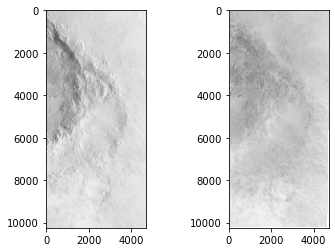

In [4]:
#We build subsets with the dimension of the overlap
print(img1.data.shape)
img1cut=img1.data[:,img1_yoff:img1_yoff+img1_ysize,img1_xoff:img1_xoff+img1_xsize]
img2cut=img2.data[:,img2_yoff:img2_yoff+img2_ysize,img2_xoff:img2_xoff+img2_xsize]
print(img2cut.shape)
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1cut[0,:,:],cmap='Greys')
axarr[1].imshow(img2cut[0,:,:],cmap='Greys')

In [5]:
# Now we create pathes with a defined patch size for our tensors.
psize=256
if img1.projection != img2.projection:
    print(False)
npx = int(img1cut.shape[2]/psize)
npy = int(img1cut.shape[1]/psize)
patches1=[]
patches2=[]
for x in range(0,npx):
    for y in range(0,npy):
        patch1 = img1cut[:,y*psize:y*psize+(psize),x*psize:x*psize+(psize)]
        #patch1 = patch1/patch1.max()*255 # FALSCH
        patch2 = img2cut[:,y*psize:y*psize+(psize),x*psize:x*psize+(psize)]
        #patch2 = patch2/patch2.max()*255
        if np.isnan(patch1).any():
            continue
        if np.isnan(patch2).any():
            continue
        patches1.append(patch1)
        patches2.append(patch2)
patches1=np.asarray(patches1)
patches2=np.asarray(patches2)

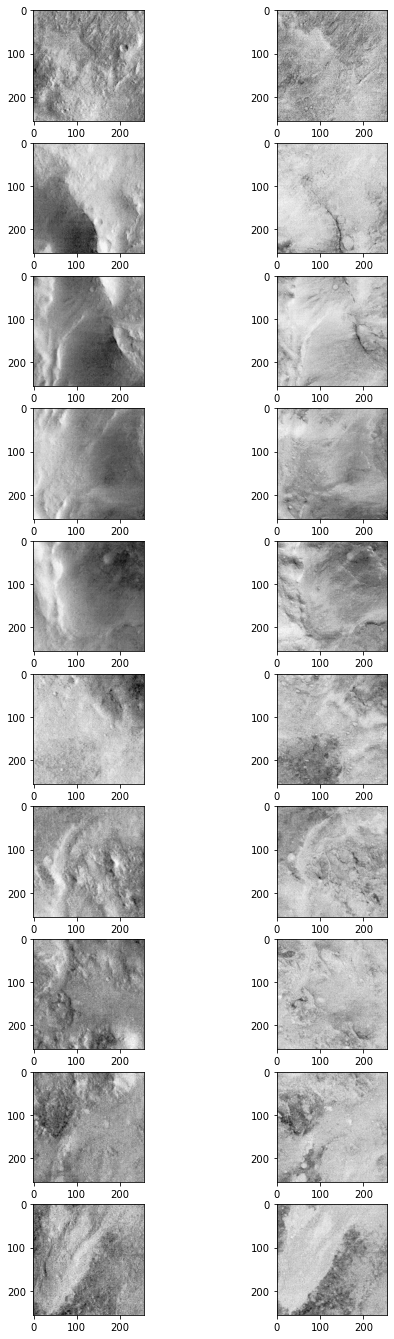

In [6]:
#Plot the first 10 patches
fig = plt.figure(figsize=(8, 24))
columns = 2
rows = 10
for idx, i in enumerate(range(1, columns*rows, 2)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(patches1[idx,0,:,:],cmap='Greys')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(patches2[idx,0,:,:],cmap='Greys')
plt.show()


In [7]:
# Cuda made trouble without this on my machine
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

In [8]:
# From http://spatial-ecology.net/docs/build/html/CASESTUDY/CNN_satelite.html
import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom

class MyDataset(Dataset):
    def __init__(self, data1, data2):
        print('data.dtype: {}'.format(data1.dtype))
        print('target.dtype: {}'.format(data2.dtype))
        self.data1 = torch.from_numpy(data1[:,0,:,:]).float()
        self.data1 = self.data1[:,None,:,:]
        self.data2 = torch.from_numpy(data2[:,0,:,:]).float()
        self.data2 = self.data2[:,None,:,:]
        
    def __getitem__(self, index):
        x1 = self.data1[index]
        x2 = self.data2[index]
        return {'A': x1, 'B': x2}
    
    def __len__(self):
        return len(self.data1)

batch_size=2
test_split=0.2
dataset = MyDataset(patches1, patches2)
#del x_train, t_train
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
train_indices, val_indices = indices[split:], indices[:split]

# -- create dataloaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=patches1.shape[0], shuffle=False),
    }

data.dtype: float32
target.dtype: float32
dataset_size: 642
split: 128


In [9]:
#Some variables for the network
cuda=True
epoch=0
n_epochs=200
lr=0.0002
decay_epoch=100
size=256
input_nc=1
output_nc=1


In [10]:
# Now the definition of the network
# Code after this: https://github.com/aitorzip/PyTorch-CycleGAN
import itertools
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import LambdaLR
from utils import Logger
from utils import weights_init_normal
#from datasets import ImageDataset

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batch_size, input_nc, size, size)
input_B = Tensor(batch_size, output_nc, size, size)
target_real = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Loss plot using Visdom
logger = Logger(n_epochs, len(dataloaders['train']))


Setting up a new session...


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
###### Training ######
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloaders['train']):
        #print(input_A.copy_(batch['A']),input_B.copy_(batch['B']))
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))
        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0
        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0
        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0
        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()

        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        #print(epoch, loss_G.data)
        #print(real_A.shape)
        # Progress report (http://localhost:8097)
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)},
                    images={'real_A': real_A[:,0,:,:], 'real_B': real_B[:,0,:,:], 'fake_A': fake_A[:,0,:,:], 'fake_B': fake_B[:,0,:,:]})
        
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')
###################################


/opt/anaconda3/envs/geocomp-ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 001/200 [0257/0257] -- loss_G: 4.6604 | loss_G_identity: 0.9884 | loss_G_GAN: 1.8147 | loss_G_cycle: 1.8573 | loss_D: 0.0626 -- ETA: 14:54:47.8269198.597541
Epoch 002/200 [0257/0257] -- loss_G: 4.2055 | loss_G_identity: 0.7847 | loss_G_GAN: 1.9388 | loss_G_cycle: 1.4820 | loss_D: 0.0391 -- ETA: 14:56:28.908569
Epoch 003/200 [0257/0257] -- loss_G: 4.1517 | loss_G_identity: 0.7370 | loss_G_GAN: 1.9784 | loss_G_cycle: 1.4363 | loss_D: 0.0029 -- ETA: 14:52:56.067105
Epoch 004/200 [0257/0257] -- loss_G: 3.9929 | loss_G_identity: 0.6992 | loss_G_GAN: 1.9834 | loss_G_cycle: 1.3104 | loss_D: 0.0474 -- ETA: 14:48:46.573277
Epoch 005/200 [0257/0257] -- loss_G: 3.8834 | loss_G_identity: 0.6459 | loss_G_GAN: 1.9755 | loss_G_cycle: 1.2621 | loss_D: 0.0075 -- ETA: 14:44:29.436673
Epoch 006/200 [0257/0257] -- loss_G: 3.7566 | loss_G_identity: 0.5961 | loss_G_GAN: 1.9847 | loss_G_cycle: 1.1758 | loss_D: 0.0015 -- ETA: 14:40:08.874774
Epoch 007/200 [0257/0257] -- loss_G: 3.7276 | loss_G_identity:

In [13]:
##### TEST
from torchvision.utils import save_image
import sys

# Load state dicts
netG_A2B.load_state_dict(torch.load('output/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('output/netG_B2A.pth'))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

dataloader = dataloaders['test']

reala=[]
realb=[]
fakea=[]
fakeb=[]

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))
    reala.append(real_A.detach().to("cpu").numpy())
    realb.append(real_B.detach().to("cpu").numpy())
    
    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
    
    fakea.append(fake_A.detach().to("cpu").numpy())
    fakeb.append(fake_B.detach().to("cpu").numpy())

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')


Generated images 0064 of 0064


1

In [14]:
#plt.imshow(reala[0][1,0,:,:],cmap='Greys')
print(realb[0].shape)

(2, 1, 256, 256)


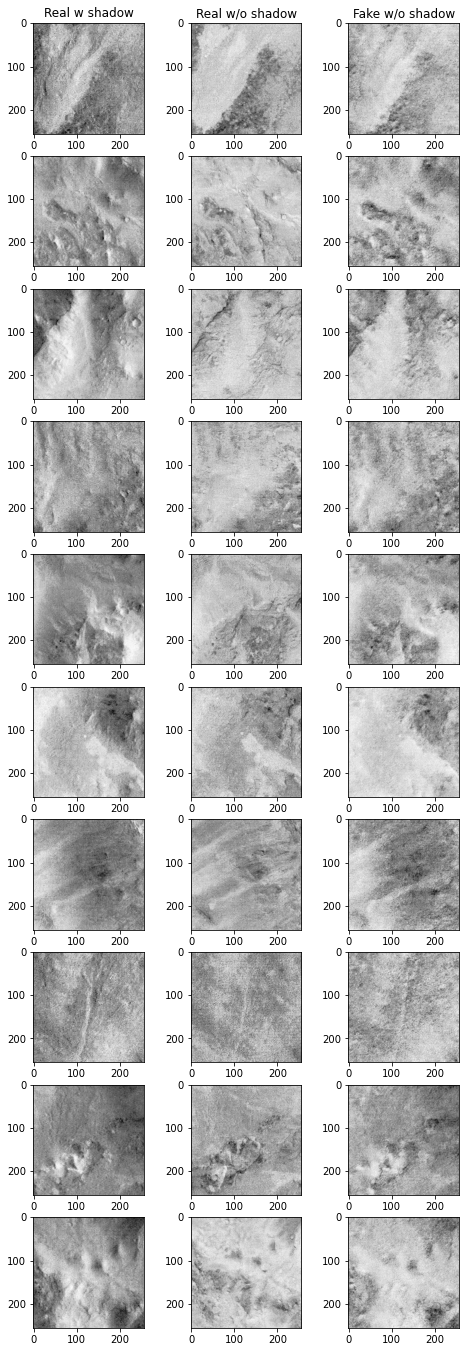

In [21]:
# Now compare test samples with results
fig = plt.figure(figsize=(8, 24))
columns = 3
rows = 10
for idx, i in enumerate(range(1, columns*rows, 3)):
    ax1=fig.add_subplot(rows, columns, i)
    plt.imshow(reala[idx][0,0,:,:],cmap='Greys')
    ax2=fig.add_subplot(rows, columns, i+1)
    plt.imshow(realb[idx][0,0,:,:],cmap='Greys')
    ax3=fig.add_subplot(rows, columns, i+2)
    plt.imshow(fakeb[idx][0,0,:,:],cmap='Greys')
    if i<4:
        ax1.set_title("Real w shadow")
        ax2.set_title("Real w/o shadow")
        ax3.set_title("Fake w/o shadow")
plt.show()